# Importing GPU and Drive Access

we begin by downloading all of the relevant data into the colab workspace. because the data are stored in [this public Google Drive folder](https://drive.google.com/drive/folders/1XQ6-veO_PCG5nlYDCvqpoc1ftsESQO_2), Google requires you to authenticate the request with a Google account (any Google account!)

In [ ]:
from google.colab import auth
auth.authenticate_user()  # must authenticate

'''list all ids of files directly under folder folder_id'''
def folder_list(folder_id):
  from googleapiclient.discovery import build
  gdrive = build('drive', 'v3').files()
  res = gdrive.list(q="'%s' in parents" % folder_id).execute()
  return [f['id'] for f in res['files']]

'''download all files from a gdrive folder to current directory'''
def folder_download(folder_id):
  for fid in folder_list(folder_id):
    !gdown -q --id $fid


In [ ]:
# this is the folder ID for our public Drive. downloading may take a moment.
folder_download('1XQ6-veO_PCG5nlYDCvqpoc1ftsESQO_2')

Colab lets us use GPUs which speeds up computation.

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Tue Jul 20 00:59:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    35W / 250W |    347MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import heapq
import json
import itertools
import scipy.spatial.distance

import pandas as pd
import numpy as np

from numpy.random import randint
from scipy.special import softmax
from sklearn.preprocessing import MinMaxScaler, normalize
from numpy.linalg import matrix_power
from functools import lru_cache

In [ ]:
def read_vecs (path_to_df):
  with tf.device('/device:GPU:0'):
    vecs_pd = pd.read_csv(path_to_df, sep=',',header=None)
    # drop first row of indices
    vecs_pd_new = vecs_pd.iloc[1:]
    # drop first column of indices
    vecs_pd_new = vecs_pd_new.drop([vecs_pd_new.columns[0]], axis = 1)
    # convert to np array
    vecs_np = vecs_pd_new.values
    return vecs_np

# Import large dataframe giving the full vocabulary

In [ ]:
with tf.device('/device:GPU:0'):
  sample_df = pd.read_csv("connector_final.csv")
  indices = sample_df.index
  print(sample_df.head())

       Word  Occurrences  Length  LgSUBTLWF
0         a          4.0       1      6.018
1  aardvark          NaN       8      1.000
2    abacus          1.0       6      1.114
3   abandon          1.0       7      2.617
4     abbey          1.0       5      2.212


# Read in Pretrained Semantic Vectors

In [ ]:
representations = {}
with tf.device('/device:GPU:0'):
  # for each of 12218 words, we have (1) glove, (2) SWOW, and (3) non-contextual BERT embeddings
  # (swow has 2 versions : PPMI and Random Walk) -- we use RW 
  # bert context-free embeddings obtained by "CLS [word] SEP": summed across last four layers (768-dim)
  representations['glove'] = read_vecs("swow12217_glove2017wiki_vectors.csv")
  representations['swow'] = np.array(pd.read_csv("SWOW_R123_rw_k300.csv", header=None))
  representations['bert-sum'] = read_vecs("bert_contextfree_sum.csv")

# Read in the game boards used in the experiment

In [ ]:
with open('boards.json', 'r') as json_file:
  boards_new = json.load(json_file)

# Read in the clues produced in the experiment

In [ ]:
## here we get the data for the experiment
with tf.device('/device:GPU:0'):
  expdata = pd.read_csv("/content/drive/My Drive/Connector-RSA-Project/final_board_clues_all.csv", encoding= 'unicode_escape')
  print(expdata.head()) 
  print('we have', len(expdata), 'rows of data')

  Experiment       Board Word1    Word2      Clue1  clueCount        wordpair
0         E1  TrialList1  exam  algebra   calculus          1  exam - algebra
1         E1  TrialList1  exam  algebra   equation          1  exam - algebra
2         E1  TrialList1  exam  algebra  knowledge          1  exam - algebra
3         E1  TrialList1  exam  algebra       math         22  exam - algebra
4         E1  TrialList1  exam  algebra     school          2  exam - algebra
we have 1096 rows of data


# RSA functions

## Extract wordpairs
For each board, we need to get all of the possible pairs of words on the board in an easy-to-work-with format

In [ ]:
## these combos need to be created at the board level
def compute_board_combos(board_name):
  board = boards[board_name]
  all_possible_combs = list(itertools.combinations(board, 2))
  combs_df = pd.DataFrame(all_possible_combs, columns =['Word1', 'Word2'])
  combs_df["wordpair"] = combs_df["Word1"] + '-'+ combs_df["Word2"]
  return combs_df

allcombinations_df = pd.DataFrame(columns=['Board', 'Word1','Word2', 'wordpair'])
board_combos = {board_name : compute_board_combos(board_name) for board_name in boards.keys()}
for board in board_combos:
  newdf = board_combos[board]
  newdf.insert(loc=0, column='Board', value=board)
  allcombinations_df = pd.concat([allcombinations_df, newdf])

allcombinations_df.head()

In [ ]:
allcombinations_df.to_csv("allcombinations_df.csv")

now that we have the combos, we can make a little helper function to get the wordpair lists for a given board as needed

In [ ]:
def get_wordpair_list(board_name) :
  return list(board_combos[board_name]['wordpair'])

['heavy-meter', 'heavy-kitchen', 'heavy-heart', 'heavy-old', 'heavy-new', 'heavy-dim', 'heavy-worn', 'heavy-boots', 'heavy-love', 'heavy-glass', 'heavy-cage', 'heavy-full', 'heavy-empty', 'heavy-east', 'heavy-short', 'heavy-hard', 'heavy-soft', 'heavy-wood', 'heavy-timber', 'meter-kitchen', 'meter-heart', 'meter-old', 'meter-new', 'meter-dim', 'meter-worn', 'meter-boots', 'meter-love', 'meter-glass', 'meter-cage', 'meter-full', 'meter-empty', 'meter-east', 'meter-short', 'meter-hard', 'meter-soft', 'meter-wood', 'meter-timber', 'kitchen-heart', 'kitchen-old', 'kitchen-new', 'kitchen-dim', 'kitchen-worn', 'kitchen-boots', 'kitchen-love', 'kitchen-glass', 'kitchen-cage', 'kitchen-full', 'kitchen-empty', 'kitchen-east', 'kitchen-short', 'kitchen-hard', 'kitchen-soft', 'kitchen-wood', 'kitchen-timber', 'heart-old', 'heart-new', 'heart-dim', 'heart-worn', 'heart-boots', 'heart-love', 'heart-glass', 'heart-cage', 'heart-full', 'heart-empty', 'heart-east', 'heart-short', 'heart-hard', 'heart-

## Board Matrix of Similarity Products

In [ ]:
## we need to create a exp(clue-w1 * clue-cw2) matrix of size Nx190 for each board
## where N is the size of the search space
## this is normalized by-row for literal guesser
## normalized by column for pragmatic speaker
## and then normalized by row again for pragmetic guesser
def create_board_matrix(combs_df, context_board, embeddings):
  # grab subset of words in given board and their corresponding glove vectors
  board_df = sample_df[sample_df['Word'].isin(context_board)]
  board_word_indices = list(board_df.index)
  board_words = board_df["Word"]
  board_vectors = embeddings[board_word_indices]

  ## clue_sims is the similarity of ALL clues in full searchspace (size N) to EACH word on board (size 20)
  clue_sims = 1 - scipy.spatial.distance.cdist(board_vectors, embeddings, 'cosine')

  ## once we have the similarities of the clue to the words on the board
  ## we define a multiplicative function that maximizes these similarities
  board_df.reset_index(inplace = True)

  ## next we find the product of similarities between c-w1 and c-w2 for that specific board's 190 word-pairs
  ## this gives us a 190 x N array of product similarities for a given combs_df
  ## specifically, for each possible pair, pull out 
  f_w1_list =  np.array([clue_sims[board_df[board_df["Word"]==row["Word1"]].index.values[0]]
                         for  index, row in combs_df.iterrows()])
  f_w2_list =  np.array([clue_sims[board_df[board_df["Word"]==row["Word2"]].index.values[0]] 
                         for  index, row in combs_df.iterrows()])
  
  # result is of length 190 for the product of similarities (i.e. how similar each word i is to BOTH in pair)
  return ((f_w1_list + 1) /2) * ((f_w2_list + 1)/2)

In [ ]:
board_matrices = {key : {board_name : create_board_matrix(board_combos[board_name], boards[board_name], embedding) 
                         for board_name in boards.keys()}
                  for (key, embedding) in representations.items()}

## Literal Guesser NP

In [ ]:
#@lru_cache(maxsize=None)
def literal_guesser_np(board_name, representation):
  ## given a 190xN matrix of clue-w1 * clue-w2 products, 
  ## literal guesser computes softmax over pairs for each possible clue
  boardmatrix = board_matrices[representation][board_name]
  return softmax(boardmatrix, axis=0)

## Pragmatic Speaker NP

In [ ]:
#@lru_cache(maxsize=None)
def pragmatic_speaker_np(board_name, beta, costweight, representation):
  ## given a Nx190 matrix of clue products, pragmatic speaker first computes literal guesser softmax for each clue in searchspace
  ## then computes softmax over all clues for a specific word-pair
  ## now we have a Nx190 array with literal guesser softmax values for each possible clue
  literal_guesser_prob = np.log(literal_guesser_np(board_name, representation))

  ## need to implement S1 = beta * (ln(G0)- cost)
  ## we use frequency-based cost (higher frequency means lower cost)
  clues_cost = -np.array(list(sample_df["LgSUBTLWF"]))
  utility = (1-costweight) * literal_guesser_prob - costweight * clues_cost
  return softmax(beta * utility, axis = 1)

In [ ]:
y = pragmatic_speaker_np('e2_board7_words', 18.858, .004, 'bert-sum')
wordpairlist = get_wordpair_list('e2_board7_words')
wordpair_index = wordpairlist.index('glass-cage')
y[wordpair_index, :].argsort()[-5:][::-1].tolist()

[1493, 6603, 9804, 10700, 8726]

In [ ]:
list(sample_df["Word"])[9804]

'sky'

In [ ]:
wordpair_index = wordpairlist.index('old-new')
y[wordpair_index, :].argsort()[-5:][::-1].tolist()

[7419, 7177, 3779, 8322, 4273]

In [ ]:
list(sample_df["Word"])[4273]

'former'

## Pragmatic Guesser NP

In [ ]:
#@lru_cache(maxsize=None)
def pragmatic_guesser_np(board_name, beta, costweight, representation):
  ## given a 190xN matrix of clue products, pragmatic guesser computes
  ## pragamtic speaker softmax for EACH wordpair given a particular clue
  return softmax(np.log(pragmatic_speaker_np(board_name, beta, costweight, representation)), axis = 0)

In [ ]:
x = literal_guesser_np('e1_board1_words', 'bert-sum')
z = pragmatic_guesser_np('e2_board1_words', 18.858, 0.004, 'bert-sum')
wordpairlist = get_wordpair_list('e1_board1_words')

clue = "band"
clue_index = list(sample_df["Word"]).index(clue)
clue_literal = x[:,clue_index]
clue_pragmatic = z[:,clue_index]
print('literal', wordpairlist[np.argmax(clue_literal)])
print('pragmatic', wordpairlist[np.argmax(clue_pragmatic)])

literal abnormal-outfit
pragmatic algebra-outfit


## Combining All Models

In [ ]:
## here we bring it all together to get predictions from each of the models 
## once the board softmaxes have been created
clue = 'equation'
target = 'exam-algebra'
wordpairlist = get_wordpair_list('e1_board1_words')

target_index = wordpairlist.index(target)
clue_index = list(sample_df["Word"]).index(clue)

a = literal_guesser_np('e1_board1_words', 'glove')[:,clue_index]
print("literal guesser prediction is:", wordpairlist[np.argmax(a)])

y = pragmatic_speaker_np('e1_board1_words', 18.858, 0.004, 'glove')
top10 = y[target_index,:].argsort()[-5:][::-1].tolist()
top10_words = [list(sample_df["Word"])[x] for x in top10]
print("top10 prag speaker predictions are:", top10_words)

z = pragmatic_guesser_np('e1_board1_words', 18.858, 0.004, 'glove')[:,clue_index]
print("pragmatic guesser prediction is:", wordpairlist[np.argmax(z)])

literal guesser prediction is: algebra-better
top10 prag speaker predictions are: ['algebra', 'exam', 'mathematics', 'exams', 'calculus']
pragmatic guesser prediction is: depth-algebra


In [ ]:
expdata.head()

,Experiment,Board,Word1,Word2,Clue1,clueCount,wordpair
0,E1,TrialList1,exam,algebra,calculus,1,exam - algebra
1,E1,TrialList1,exam,algebra,equation,1,exam - algebra
2,E1,TrialList1,exam,algebra,knowledge,1,exam - algebra
3,E1,TrialList1,exam,algebra,math,22,exam - algebra
4,E1,TrialList1,exam,algebra,school,2,exam - algebra


# Generate predictions

In [ ]:
## create boards and merge with expdata
combined_boards_df = pd.DataFrame(columns=['Experiment', 'Board','boardwords'])
combined_boards_df["Experiment"]  = ["E1","E1","E1","E1","E1","E1","E1","E1","E1","E1",
                                     "E2","E2","E2","E2","E2","E2","E2","E2","E2","E2"]
combined_boards_df["Board"] = ["TrialList1", "TrialList2","TrialList3","TrialList4","TrialList5",
                                   "TrialList6","TrialList7","TrialList8","TrialList9","TrialList10",
                                   "TrialList1", "TrialList2","TrialList3","TrialList4","TrialList5",
                                   "TrialList6","TrialList7","TrialList8","TrialList9","TrialList10"]
combined_boards_df["boardnames"] = [
   'e1_board1_words', 'e1_board2_words', 'e1_board3_words', 'e1_board4_words',
   'e1_board5_words', 'e1_board6_words', 'e1_board7_words', 'e1_board8_words', 'e1_board9_words', 
    'e1_board10_words', 'e2_board1_words', 'e2_board2_words', 'e2_board3_words', 
    'e2_board4_words', 'e2_board5_words','e2_board6_words', 'e2_board7_words', 'e2_board8_words', 
    'e2_board9_words',  'e2_board10_words'
]

combined_boards_df["boardwords"] = [boards['e1_board1_words'], boards['e1_board2_words'], boards['e1_board3_words'], 
                   boards['e1_board4_words'],boards['e1_board5_words'],boards['e1_board6_words'],
                   boards['e1_board7_words'], boards['e1_board8_words'], boards['e1_board9_words'], 
                   boards['e1_board10_words'],
                   boards['e2_board1_words'], boards['e2_board2_words'], boards['e2_board3_words'], 
                   boards['e2_board4_words'],boards['e2_board5_words'],boards['e2_board6_words'],
                   boards['e2_board7_words'], boards['e2_board8_words'], boards['e2_board9_words'], 
                   boards['e2_board10_words']]
combined_boards_df.head()

,Experiment,Board,boardwords,boardnames
0,E1,TrialList1,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words
1,E1,TrialList2,"[alto, faith, beginning, brake, birds, aircraf...",e1_board2_words
2,E1,TrialList3,"[circle, dance, day, dark, famine, calorie, hu...",e1_board3_words
3,E1,TrialList4,"[ceiling, carpet, corpse, fight, extension, fa...",e1_board4_words
4,E1,TrialList5,"[ancestor, child, carriage, done, denial, disr...",e1_board5_words


In [ ]:
with tf.device('/device:GPU:0'):
  target_df = pd.read_csv("/content/drive/My Drive/Connector-RSA-Project/connector_wordpairs_boards.csv")
  target_df["wordpair"]= connector_online["Word1"]+ "-"+connector_online["Word2"]
  ## need to get similarity matrix of these words in THIS order to work with
  print(target_df.head())

     Word1     Word2 Experiment        boardnames         wordpair
0     void     couch         E1   e1_board1_words       void-couch
1   giggle  abnormal         E1   e1_board1_words  giggle-abnormal
2     exam   algebra         E1   e1_board1_words     exam-algebra
3      tea      bean         E1  e1_board10_words         tea-bean
4  tourist    comedy         E1  e1_board10_words   tourist-comedy


## Optimizing speaker params

In [ ]:
softplus = lambda x: np.log1p(np.exp(x))
from scipy.special import expit
import psutil
import sys

In [ ]:
representation = 'glove'

def get_board_speaker_likelihood(params):
  representation_model = representations[representation]
  speaker_prob = []
  beta = softplus(params[0])
  alpha = expit(params[1])
  for index, row in combined_boards_df.iterrows():
    # grab subset of words in given board and their corresponding glove vectors
    boardname = row["boardnames"]
    board_df = sample_df[sample_df['Word'].isin(boards[boardname])]
    board_word_indices = list(board_df.index)
    board_words = board_df["Word"]
    board_vectors = representation_model[board_word_indices]

    ## clue_sims is the similarity of ALL clues in full searchspace (size N) to EACH word on board (size 20)
    clue_sims = (1-scipy.spatial.distance.cdist(board_vectors, representation_model, 'cosine') + 1) / 2
    target_sample = target_df[target_df['Word1'].isin(board_df["Word"]) & target_df['Word2'].isin(board_df["Word"])]
    w1_index = [list(board_df["Word"]).index(row["Word1"]) for index, row in target_sample.iterrows()]
    w2_index = [list(board_df["Word"]).index(row["Word2"]) for index, row in target_sample.iterrows()]
    clue_w1 = clue_sims[w1_index]
    clue_w2 = clue_sims[w2_index]
    clue_prod = np.multiply(clue_w1, clue_w2)
    clue_sims_new = np.array([np.delete(clue_sims, [w1_index[i], w2_index[i]], axis=0) for i in range(len(w1_index))])
    avg_sim = np.mean(clue_sims_new, axis=1)
    func = np.subtract((alpha)*clue_prod, (1-alpha)*avg_sim)
    y = softmax(beta * func, axis=1)
    expdata_board = expdata[(expdata["Board"] == row["Board"]) & (expdata["Experiment"] == row["Experiment"])]
    speaker_word_pairs = list(target_sample['wordpair'])
    for index, row in expdata_board.iterrows():
      wordpair = str(row["wordpair"]).replace(" ", "")
      wordpair_index = speaker_word_pairs.index(wordpair)
      clue1 = row["Clue1"]
      if clue1 in list(sample_df["Word"]):
        # find index of clue
        clue_index = list(sample_df["Word"]).index(clue1)
        clue_probs = y[wordpair_index, clue_index]
        speaker_prob.append(row['clueCount'] * np.log(clue_probs))
      if(psutil.virtual_memory().available < 100000) :
        sys.exit('oom')
  print(beta, alpha, '(', params[1], ')', ':', np.sum(speaker_prob))
  return -np.sum(speaker_prob)

#scipy.optimize.minimize(get_board_speaker_likelihood, [24, 3.349]) # optimize for 'swow'
#scipy.optimize.minimize(get_board_speaker_likelihood, [20.6, 3.349]) # optimize for 'glove'
scipy.optimize.minimize(get_board_speaker_likelihood, [1, 5]) # optimize for 'bert-sum'

1.3132616875182228 0.9933071490757153 ( 5.0 ) : -19153.533109759843
1.3132616875182228 0.9933071490757153 ( 5.0 ) : -19153.533109759843
1.3132616984118446 0.9933071490757153 ( 5.0 ) : -19153.533106781462
1.3132616875182228 0.993307149174779 ( 5.000000014901161 ) : -19153.533109714666
2.135638778554892 0.9934082185337044 ( 5.015318035068566 ) : -18930.678606399386
2.135638778554892 0.9934082185337044 ( 5.015318035068566 ) : -18930.678606399386
2.135638791695196 0.9934082185337044 ( 5.015318035068566 ) : -18930.67860287252
2.135638778554892 0.9934082186312821 ( 5.015318049969728 ) : -18930.678606328584
6.05177562238219 0.9937975563904909 ( 5.076590175342831 ) : -17928.95355733127
6.05177562238219 0.9937975563904909 ( 5.076590175342831 ) : -17928.95355733127
6.051775637248278 0.9937975563904909 ( 5.076590175342831 ) : -17928.95355373067
6.05177562238219 0.9937975564823414 ( 5.0765901902439925 ) : -17928.95355716371
22.207560510349854 0.995139195854484 ( 5.32167873643989 ) : -15798.8833043

KeyboardInterrupt: ignored

In [ ]:
representation = 'swow'

def get_rsa_speaker_likelihood(params) :
  # params is a list
  speaker_prob = []
  beta = softplus(params[0])
  costweight = expit(params[1])
  for index, row in combined_boards_df.iterrows():
    board = row["boardwords"]
    boardname = row["boardnames"]
    wordpairlist = get_wordpair_list(boardname)
    speaker_word_pairs = target_df[(target_df["boardnames"] == row["boardnames"]) & 
                                   (target_df["Experiment"] == row["Experiment"])]["wordpair"]
    speaker_model = pragmatic_speaker_np(boardname, beta, costweight, representation)
    y = np.array([speaker_model[wordpairlist.index(wordpair)] for wordpair in speaker_word_pairs])
    expdata_board = expdata[(expdata["Board"] == row["Board"]) & (expdata["Experiment"] == row["Experiment"])]
    speaker_word_pairs = list(speaker_word_pairs)
    for index, row in expdata_board.iterrows():
      wordpair = str(row["wordpair"]).replace(" ", "")
      wordpair_index = speaker_word_pairs.index(wordpair)
      clue1 = row["Clue1"]
      if clue1 in list(sample_df["Word"]):
        clue_index = list(sample_df["Word"]).index(clue1)
        clue_probs = y[wordpair_index, clue_index]
        speaker_prob.append(row['clueCount'] * np.log(clue_probs))
      if(psutil.virtual_memory().available < 100000) :
        sys.exit('out of memory')
  print(beta, costweight, '(', params[1], ')', ':', np.sum(speaker_prob))
  return -np.sum(speaker_prob)

scipy.optimize.minimize(get_rsa_speaker_likelihood, [25.399, -3.219]) # optimize for 'swow'

25.39900000000932 0.03845694644913565 ( -3.219 ) : -17574.701737620453
25.39900000000932 0.03845694644913565 ( -3.219 ) : -17574.701737620453
25.39900001491048 0.03845694644913565 ( -3.219 ) : -17574.701737424184
25.39900000000932 0.03845694700015094 ( -3.2189999850988387 ) : -17574.70173917102
25.52583247357692 0.0144713872612242 ( -4.221004752308332 ) : -17923.780255553986
25.52583247357692 0.0144713872612242 ( -4.221004752308332 ) : -17923.780255553986
25.52583248847808 0.0144713872612242 ( -4.221004752308332 ) : -17923.780255064084
25.52583247357692 0.01447138747374406 ( -4.221004737407171 ) : -17923.780249055962
25.40751537089948 0.036045108791740416 ( -3.2862733240912734 ) : -17572.405030278733
25.40751537089948 0.036045108791740416 ( -3.2862733240912734 ) : -17572.405030278733
25.40751538580064 0.036045108791740416 ( -3.2862733240912734 ) : -17572.4050300033
25.40751537089948 0.03604510930949406 ( -3.286273309190112 ) : -17572.40502975854
25.677549008205837 0.03569646894776818 (

KeyboardInterrupt: ignored

## Speaker predictions

In [ ]:
rsa_optimal_params = {
    'swow' : (25.1522030761838, 0.03863169001849234),
    'glove' : (22.336514544537227, 0.039),
    'bert-sum' : (29.709602301411962, 0.031659060110267576), #-17533
}

board_optimal_params = {
    'swow' : (23.488850322875496, 1), # -13204
    'glove' : (20.952928531665275, 1), # -15774.814774380024)
    'bert-sum' : (19.983835225540847, 0.787924454045298),
}

In [ ]:
## we also want scores for our different clues produced by the participant
speakerprobs_df = pd.DataFrame(columns=['representation', 'Experiment','Board', "Word1", "Word2", "Clue1", "clueCount", "wordpair", "prag_speaker_probs"])

for representation in representations.keys() :
  for index, row in combined_boards_df.iterrows():
    board = row["boardwords"]
    boardname = row["boardnames"]
    wordpairlist = get_wordpair_list(boardname)
    speaker_word_pairs = target_df[(target_df["boardnames"] == row["boardnames"]) & 
                                   (target_df["Experiment"] == row["Experiment"])]["wordpair"]
    speaker_df_new = pd.DataFrame({'wordpair': speaker_word_pairs})
    params = rsa_optimal_params[representation]
    speaker_model = pragmatic_speaker_np(boardname, params[0], params[1], representation)

    ## this is created at the BOARD level
    y = np.array([speaker_model[wordpairlist.index(wordpair)] for wordpair in speaker_word_pairs])

    ## so y has 3 vectors of clue probabilities (the 3 pairs on this board)
    ## now we need to go into expdata and figure out the probabilities for those specific clues
    expdata_board = expdata[(expdata["Board"] == row["Board"]) & (expdata["Experiment"] == row["Experiment"])]

    speaker_prob = []
    speaker_rank = []
    speaker_word_pairs = list(speaker_word_pairs)
    print(speaker_word_pairs)
    for index, row in expdata_board.iterrows():
      wordpair = str(row["wordpair"]).replace(" ", "")
      wordpair_index = speaker_word_pairs.index(wordpair)
      w1_index, w2_index = [list(sample_df["Word"]).index(word) for word in wordpair.split('-')]

      y_sorted = np.argsort(-y)
      clue1 = row["Clue1"]
      if clue1 in list(sample_df["Word"]):
        # find index of clue
        clue_index = list(sample_df["Word"]).index(clue1)
        clue_probs = y[wordpair_index, clue_index]
        clue_rank = np.nonzero(y_sorted==clue_index)[1][wordpair_index]
      else:
        clue_probs = "NA"
      
      speaker_prob.append(clue_probs)
      speaker_rank.append(clue_rank)
    expdata_board["representation"] = representation
    expdata_board["prag_speaker_probs"] = speaker_prob
    expdata_board["prag_speaker_rank"] = speaker_rank
    speakerprobs_df = pd.concat([speakerprobs_df, expdata_board])

['void-couch', 'giggle-abnormal', 'exam-algebra']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

['beginning-brake', 'birds-aircraft', 'school-stop']
['circle-dance', 'famine-calorie', 'hundred-economy']
['corpse-fight', 'graph-copy', 'kitchen-egg']
['near-astronaut', 'homeless-apartment', 'onion-cigarette']
['pants-collar', 'definition-assist', 'war-quiet']
['flat-alike', 'perjury-adultery', 'heavy-feather']
['breeze-bubble', 'bad-actress', 'communicate-cooking']
['bat-bounce', 'toes-Dracula', 'lunch-almond']
['tea-bean', 'tourist-comedy', 'pendulum-dusk']
['cave-knight', 'quick-glow', 'tree-oak']
['stern-wind', 'sun-bowl', 'gold-silver']
['holy-kind', 'teeth-gums', 'rude-regret']
['dream-bet', 'jump-leap', 'travel-ankle']
['snake-ash', 'hand-birth', 'lion-tiger']
['elm-rock', 'crust-boot', 'sit-stand']
['east-short', 'old-new', 'glass-cage']
['giant-subtle', 'army-drum', 'happy-sad']
['weird-trauma', 'olive-real', 'candle-wick']
['garage-bone', 'feet-chapel', 'chair-table']
['void-couch', 'giggle-abnormal', 'exam-algebra']
['beginning-brake', 'birds-aircraft', 'school-stop']
['c

In [ ]:
speakerprobs_df

,representation,Experiment,Board,Word1,Word2,Clue1,clueCount,wordpair,prag_speaker_probs,prag_speaker_rank
0,glove,E1,TrialList1,exam,algebra,calculus,1,exam - algebra,0.00202531,11.0
1,glove,E1,TrialList1,exam,algebra,equation,1,exam - algebra,0.000493262,147.0
2,glove,E1,TrialList1,exam,algebra,knowledge,1,exam - algebra,0.000239471,474.0
3,glove,E1,TrialList1,exam,algebra,math,22,exam - algebra,0.00315314,5.0
4,glove,E1,TrialList1,exam,algebra,school,2,exam - algebra,0.00118146,31.0
...,...,...,...,...,...,...,...,...,...,...
580,bert-sum,E2,TrialList10,garage,bone,storage,5,garage - bone,0.000157688,1544.0
581,bert-sum,E2,TrialList10,garage,bone,structure,1,garage - bone,0.000127559,2274.0
582,bert-sum,E2,TrialList10,garage,bone,tool,1,garage - bone,0.000117604,2566.0
583,bert-sum,E2,TrialList10,garage,bone,trash,2,garage - bone,0.00010673,2916.0


In [ ]:
speakerprobs_df.to_csv("speaker_ranks.csv")
!cp speaker_ranks.csv "drive/My Drive/Connector-RSA-Project/"

In [ ]:
## Creating a mainlist of boards
speaker_df = pd.DataFrame(columns=['representation', 'wordpair','Board', 'prag_speaker_words'])

for representation in representations.keys() :
  for index, row in combined_boards_df.iterrows():
    board_words = row["boardwords"]
    boardname = row["boardnames"]
    wordpairlist = get_wordpair_list(boardname)
    params = optimal_params[representation]
    speaker_model = pragmatic_speaker_np(boardname, params[0], params[1], representation)
    ## get empirical speaker probs for this board
    speaker_word_pairs = target_df[(target_df["boardnames"] == row['boardnames']) & 
                                          (target_df["Experiment"] == row['Experiment'])]["wordpair"]
    speaker_df_new = pd.DataFrame({'wordpair': speaker_word_pairs})
    speaker_df_new["Board"] = boardname
    speaker_df_new["representation"] = representation
    y = np.array([speaker_model[wordpairlist.index(wordpair)] for wordpair in speaker_word_pairs])

    ## this will yield 3x10191 array [1-d array for each word-pair, 3 word-pairs per board]
    ## from here we sort each row in descending order 
    y_sorted = np.argsort(-y) ## gives sorted indices
    ## only need top 20 from here
    top20_indices = y_sorted[:,:20]

    ## convert to words
    w1 = [list(sample_df["Word"])[i] for i in top20_indices[0]]
    w2 = [list(sample_df["Word"])[i] for i in top20_indices[1]]
    w3 = [list(sample_df["Word"])[i] for i in top20_indices[2]]
    words = [w1, w2, w3]
    speaker_df_new["prag_speaker_words"] = words
    speaker_df = pd.concat([speaker_df, speaker_df_new])

speaker_df

,representation,wordpair,Board,prag_speaker_words
0,glove,void-couch,e1_board1_words,"[empty, sit, fill, floor, vacancy, stare, cush..."
1,glove,giggle-abnormal,e1_board1_words,"[giggle, abnormal, hysterical, laughter, sneez..."
2,glove,exam-algebra,e1_board1_words,"[algebra, exam, mathematics, calculus, math, g..."
6,glove,beginning-brake,e1_board2_words,"[brake, onward, accelerate, slow, switch, end,..."
7,glove,birds-aircraft,e1_board2_words,"[fly, birds, bird, Harry Potter, aircraft, pil..."
...,...,...,...,...
58,bert-sum,olive-real,e2_board9_words,"[real, olive, Santa, not real, hazel, rusty, g..."
59,bert-sum,candle-wick,e2_board9_words,"[wick, hick, widget, wicker, whack, muck, leec..."
33,bert-sum,garage-bone,e2_board10_words,"[bone, garage, tooth, joints, fatigue, jaw, bo..."
34,bert-sum,feet-chapel,e2_board10_words,"[chapel, religious, church, goats, religion, c..."


In [ ]:
speaker_df.to_csv("speaker_top.csv")
!cp speaker_top.csv "drive/My Drive/Connector-RSA-Project/"

In [ ]:
speakerprobs_df

,representation,Experiment,Board,Word1,Word2,Clue1,clueCount,wordpair,prag_speaker_probs
0,glove,E1,TrialList1,exam,algebra,calculus,1,exam - algebra,0.000659558
1,glove,E1,TrialList1,exam,algebra,equation,1,exam - algebra,0.000165116
2,glove,E1,TrialList1,exam,algebra,knowledge,1,exam - algebra,0.000111795
3,glove,E1,TrialList1,exam,algebra,math,22,exam - algebra,0.000553571
4,glove,E1,TrialList1,exam,algebra,school,2,exam - algebra,0.000124722
...,...,...,...,...,...,...,...,...,...
580,bert-sum,E2,TrialList10,garage,bone,storage,5,garage - bone,0.00017586
581,bert-sum,E2,TrialList10,garage,bone,structure,1,garage - bone,0.000141453
582,bert-sum,E2,TrialList10,garage,bone,tool,1,garage - bone,0.000122567
583,bert-sum,E2,TrialList10,garage,bone,trash,2,garage - bone,7.57142e-05


## Listener predictions

In [ ]:
guesser_df = pd.DataFrame(columns=['Experiment','Board', "Word1", "Word2", "Clue1", "clueCount", "wordpair"])

for representation in representations.keys() :
  for index, row in combined_boards_df.iterrows():
    guesser_df_board = pd.DataFrame(columns=['Experiment','Board', "Word1", "Word2", "Clue1", "clueCount", "wordpair"])
    board = row["boardwords"]
    boardname = row['boardnames']
    wordpairlist = get_wordpair_list(boardname)
    # calculate the prag guesser for this specific wordpairlist (corresponding to ONE board)
    params = rsa_optimal_params[representation]
    x = literal_guesser_np(boardname, representation)
    z = pragmatic_guesser_np(boardname, params[0], params[1], representation) 

    # then loop through the clues in expdata_board to get predictions
    expdata_board = expdata[(expdata["Board"] == row["Board"]) & (expdata["Experiment"] == row["Experiment"])]
    expdata_board["representation"] = representation

    for index, row in expdata_board.iterrows():
      clue1 = row["Clue1"]
      if clue1 in list(sample_df["Word"]):
        ## literal guesser uses "x", pragmatic guesser uses "z"
        clue_index = list(sample_df["Word"]).index(clue1)
        literal_pred = wordpairlist[np.argmax(x[:,clue_index])]
        pragmatic_pred = wordpairlist[np.argmax(z[:,clue_index])]
      else:
        literal_pred = "NA"
        pragmatic_pred = "NA"
      
      # we want to track likelihood for ALL responses (i.e. full listener distribution)
      guesser_df_clue = pd.DataFrame({
          'Clue1' : clue1, 
          'possible_wordpair' : wordpairlist,
          'literal_likelihood' : x[:, clue_index],
          'prag_likelihood' : z[:, clue_index],
          'literal_top_prediction' : literal_pred,
          'prag_top_prediction' : pragmatic_pred
      })
      guesser_df_board = pd.concat([guesser_df_board, pd.merge(expdata_board, guesser_df_clue)])
    guesser_df = pd.concat([guesser_df, guesser_df_board])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [ ]:
guesser_df

,Experiment,Board,Word1,Word2,Clue1,clueCount,wordpair,representation,possible_wordpair,literal_likelihood,prag_likelihood,literal_top_prediction,prag_top_prediction
0,E1,TrialList1,exam,algebra,calculus,1,exam - algebra,glove,angry-adore,0.005085,0.000559,exam-algebra,exam-algebra
1,E1,TrialList1,exam,algebra,calculus,1,exam - algebra,glove,angry-burglar,0.005144,0.001141,exam-algebra,exam-algebra
2,E1,TrialList1,exam,algebra,calculus,1,exam - algebra,glove,angry-rumor,0.004993,0.000292,exam-algebra,exam-algebra
3,E1,TrialList1,exam,algebra,calculus,1,exam - algebra,glove,angry-depth,0.005164,0.001033,exam-algebra,exam-algebra
4,E1,TrialList1,exam,algebra,calculus,1,exam - algebra,glove,angry-anchor,0.005167,0.001203,exam-algebra,exam-algebra
...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,E2,TrialList10,garage,bone,underground,1,garage - bone,bert-sum,ring-garage,0.005543,0.006816,gas-garage,gas-garage
186,E2,TrialList10,garage,bone,underground,1,garage - bone,bert-sum,ring-bone,0.005218,0.003020,gas-garage,gas-garage
187,E2,TrialList10,garage,bone,underground,1,garage - bone,bert-sum,ship-garage,0.005534,0.005878,gas-garage,gas-garage
188,E2,TrialList10,garage,bone,underground,1,garage - bone,bert-sum,ship-bone,0.005210,0.002564,gas-garage,gas-garage


In [ ]:
guesser_df.to_csv("guesser_scores.csv")
!cp guesser_scores.csv "drive/My Drive/Connector-RSA-Project/"

KeyError: ignored

# Adding Board Context to Speaker Task

     Word1     Word2 Experiment        boardnames
0     void     couch         E1   e1_board1_words
1   giggle  abnormal         E1   e1_board1_words
2     exam   algebra         E1   e1_board1_words
3      tea      bean         E1  e1_board10_words
4  tourist    comedy         E1  e1_board10_words


In [ ]:
## define a func that computed similarities of clue to each word on the board
## and then maximizes similarity to the words while minimizing similarity to other words

def speaker_board_func(combs_df, context_board, alpha, beta, representation_model):
  # grab subset of words in given board and their corresponding glove vectors
  board_df = sample_df[sample_df['Word'].isin(context_board)]
  #print("board_df:",board_df)
  board_word_indices = list(board_df.index)
  board_words = board_df["Word"]
  board_vectors = representation_model[board_word_indices]

  ## clue_sims is the similarity of ALL clues in full searchspace (size N) to EACH word on board (size 20)
  clue_sims = (1-scipy.spatial.distance.cdist(board_vectors, representation_model, 'cosine') + 1 ) / 2
  #print("clue_sims: ", clue_sims.shape) ## 20 x 12218 

  target_sample = target_df[target_df['Word1'].isin(board_df["Word"]) & target_df['Word2'].isin(board_df["Word"])]
  #print("target_sample:",target_sample)

  w1_index = [list(board_df["Word"]).index(row["Word1"]) for index, row in target_sample.iterrows()]
  w2_index = [list(board_df["Word"]).index(row["Word2"]) for index, row in target_sample.iterrows()]
  clue_w1 = clue_sims[w1_index]
  clue_w2 = clue_sims[w2_index]
  #print("clue_w1:", clue_w1.shape) ## 3 x 12218 sized array 
  #print("clue_w2:", clue_w2.shape) ## 3 x 12218 sized array

  clue_prod = np.multiply(clue_w1,clue_w2)
  #print("clue_prod:", clue_prod.shape) ## 3 x 12218 sized array for each of the word-pairs on the board

  # deleting the two target words to compute average similarity to other words on the board

  clue_sims_new = np.array([np.delete(clue_sims, [w1_index[i], w2_index[i]], axis=0) for i in range(len(w1_index))])
  #print("clue_sims_new:", clue_sims_new.shape)

  avg_sim = np.mean(clue_sims_new, axis=1)
  #print("avg_sim:",avg_sim.shape)

  ## FUNC = alpha(clue_w1*clue_w2) + (1-alpha)*(average of other board words)

  func = np.subtract((alpha)*clue_prod, (1-alpha)*avg_sim)
  #print("func:", func.shape) ## this is a 3x12218 array where we can find the clue with the highest value for each target word-pair
  
  return softmax(beta * func, axis=1)


In [ ]:
np.sum(speaker_board_func(board_combos['e1_board10_words'], boards['e1_board10_words'], 0.7, 20, representations['glove']), axis = 1)

array([1., 1., 1.])

## Top Predictions

In [ ]:
speaker_board_df = pd.DataFrame(columns=['Word1', 'Word2', 'boardnames','top10preds', 'alpha', 'Model'])

for representation in ['bert-sum', 'glove', 'swow']: 
  for alpha in np.arange(0,1.1, 0.1):
    ## for a given alpha, compute the clue similarities 
    params = board_optimal_params[representation]
    speaker_board_probs = {
        board_name : speaker_board_func(board_combos[board_name], boards[board_name], alpha, params[0], representations[representation]) 
        for board_name in boards.keys()
    }   
    # we calculate the top5 speaker predictions for each word-pair based on highest value above
    for board in speaker_board_probs.keys():
      ## obtain top10 indices for each word-pair
      idx = [(-speaker_board_probs[board][x]).argsort()[:10].tolist() for x in range(3)]
      a = [list(sample_df["Word"])[z] for y in idx for z in y]
      top10preds = [list(arr) for arr in np.array_split(a, 3)]

      speaker_df_new = pd.DataFrame({'boardnames': [board]*3})
      speaker_df_new["Word1"] = list(target_df[target_df['boardnames']== board]["Word1"])
      speaker_df_new["Word2"] = list(target_df[target_df['boardnames']== board]["Word2"])
      speaker_df_new["alpha"] = [alpha]*3
      speaker_df_new["top10preds"] = top10preds
      speaker_df_new["Model"] = representation
      
      speaker_board_df = pd.concat([speaker_board_df, speaker_df_new])

speaker_board_df                

,Word1,Word2,boardnames,top10preds,alpha,Model
0,void,couch,e1_board1_words,"[David Bowie, United Kingdom, mussel, North Po...",0.0,BERT-sum
1,giggle,abnormal,e1_board1_words,"[David Bowie, United Kingdom, mussel, North Po...",0.0,BERT-sum
2,exam,algebra,e1_board1_words,"[David Bowie, mussel, United Kingdom, North Po...",0.0,BERT-sum
0,beginning,brake,e1_board2_words,"[David Bowie, United Kingdom, mussel, North Po...",0.0,BERT-sum
1,birds,aircraft,e1_board2_words,"[David Bowie, mussel, United Kingdom, North Po...",0.0,BERT-sum
...,...,...,...,...,...,...
1,olive,real,e2_board9_words,"[real, olive, lemon, Thanksgiving, purple, lof...",1.0,BERT-sum
2,candle,wick,e2_board9_words,"[candle, wick, spark, wrench, cookie, hick, wa...",1.0,BERT-sum
0,garage,bone,e2_board10_words,"[bone, garage, fatigue, joints, stump, warehou...",1.0,BERT-sum
1,feet,chapel,e2_board10_words,"[cottage, sandals, tile, nuns, fabric, bathroo...",1.0,BERT-sum


In [ ]:
speaker_board_df.to_csv("speaker_boardfunc_df.csv")
!cp speaker_boardfunc_df.csv "drive/My Drive/Connector-RSA-Project/"

## Obtain Clue Score for every possible Clue

In [ ]:
# use expdata and figure out the score of that specific clue based on the alpha and model
## here we get the data for the experiment
with tf.device('/device:GPU:0'):
  expdata = pd.read_csv("/content/drive/My Drive/Connector-RSA-Project/final_board_clues_all.csv", encoding= 'unicode_escape')
expdata.head() ## 1096 rows of data

,Experiment,Board,Word1,Word2,Clue1,clueCount,wordpair
0,E1,TrialList1,exam,algebra,calculus,1,exam - algebra
1,E1,TrialList1,exam,algebra,equation,1,exam - algebra
2,E1,TrialList1,exam,algebra,knowledge,1,exam - algebra
3,E1,TrialList1,exam,algebra,math,22,exam - algebra
4,E1,TrialList1,exam,algebra,school,2,exam - algebra


In [ ]:
## merge expdata with combined_boards so we have the "boardname" correct
expdata_new = pd.merge(expdata,combined_boards_df,on=['Board', 'Experiment'],how='left')
expdata_new["wordpair"] = expdata_new["Word1"] + "-" + expdata_new["Word2"]
expdata_new.head()

,Experiment,Board,Word1,Word2,Clue1,clueCount,wordpair,boardwords,boardnames
0,E1,TrialList1,exam,algebra,calculus,1,exam-algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words
1,E1,TrialList1,exam,algebra,equation,1,exam-algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words
2,E1,TrialList1,exam,algebra,knowledge,1,exam-algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words
3,E1,TrialList1,exam,algebra,math,22,exam-algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words
4,E1,TrialList1,exam,algebra,school,2,exam-algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words


In [ ]:
target_df["wordpair"] = target_df["Word1"] + "-" + target_df["Word2"]
target_df.head()

,Word1,Word2,Experiment,boardnames,wordpair
0,void,couch,E1,e1_board1_words,void-couch
1,giggle,abnormal,E1,e1_board1_words,giggle-abnormal
2,exam,algebra,E1,e1_board1_words,exam-algebra
3,tea,bean,E1,e1_board10_words,tea-bean
4,tourist,comedy,E1,e1_board10_words,tourist-comedy


In [ ]:
clue_board_df_main = pd.DataFrame(columns=['boardnames','wordpair', 'Clue1', 'clue_score', 'alpha', 'Model'])

for representation in ['bert-sum', 'glove', 'swow']: 
  for alpha in np.arange(0,1.1, 0.1):
    ## for a given alpha, compute the clue similarities 
    beta = board_optimal_params[representation][0]
    speaker_board_probs = {
        board_name : speaker_board_func(board_combos[board_name], boards[board_name], alpha, beta, representations[representation]) 
        for board_name in boards.keys()
    }   
    
    for board in speaker_board_probs.keys():
      
      ## get the clues we need scores for from expdatanew
      clue_main = expdata_new.loc[expdata_new['boardnames'] == board]
      target_main = target_df.loc[target_df['boardnames'] == board]
      
      target_main.reset_index(inplace = True)
      #print(target_main)

      for index, row in clue_main.iterrows():
        if row["Clue1"] in list(sample_df["Word"]):
          #print("clue is:", row["Clue1"])
          clue_index = list(sample_df["Word"]).index(row["Clue1"])
          #print("clue_index:",clue_index)
          wordpair = row["wordpair"]
          ## need to figure out specific wordpair this clue corresponds to
          wordpair_index = target_main.index[(target_main['wordpair'] == wordpair)].tolist()[0]
          #print("wordpair_index:",wordpair_index)
          # get a sorted array of the clue scores
          mainscores = speaker_board_probs[board][wordpair_index]
          sorted_clue_probs = np.argsort(-mainscores).tolist()
          #print("sorted_clue_probs_indices = ", sorted_clue_probs)
          
          # we next obtain the score for each clue for a specific wordpair
          clue_similarity = speaker_board_probs[board][wordpair_index][clue_index]
          # want to find index of this particular clue in the overall distribution
          clue_rank = sorted_clue_probs.index(clue_index)
          #print("clue_rank:",clue_rank)
        else:
          clue_similarity = "NA"
          clue_rank = "NA"
        
        clue_board_df = pd.DataFrame({'boardnames': [board]})
        clue_board_df["wordpair"] = wordpair
        clue_board_df["Clue1"] = row["Clue1"]
        clue_board_df["clue_score"] = clue_similarity
        clue_board_df["clue_rank"] = clue_rank
        clue_board_df["alpha"] = alpha
        clue_board_df["Model"] = representation
          
        clue_board_df_main = pd.concat([clue_board_df_main, clue_board_df])

clue_board_df_main                

,boardnames,wordpair,Clue1,clue_score,alpha,Model,clue_rank
0,e1_board1_words,exam-algebra,calculus,7.46495e-05,0.0,bert-sum,3812
0,e1_board1_words,exam-algebra,equation,5.92828e-05,0.0,bert-sum,4913
0,e1_board1_words,exam-algebra,knowledge,3.59289e-05,0.0,bert-sum,8081
0,e1_board1_words,exam-algebra,math,6.25472e-05,0.0,bert-sum,4631
0,e1_board1_words,exam-algebra,school,6.21898e-05,0.0,bert-sum,4657
...,...,...,...,...,...,...,...
0,e2_board10_words,garage-bone,storage,0.000495596,1.0,swow,206
0,e2_board10_words,garage-bone,structure,0.000288999,1.0,swow,388
0,e2_board10_words,garage-bone,tool,0.00229715,1.0,swow,23
0,e2_board10_words,garage-bone,trash,0.00038321,1.0,swow,288


In [ ]:
list(sample_df["Word"])[2163]

'completed'

In [ ]:
1096*11*3

36168

In [ ]:
clue_board_df_main.to_csv("speaker_boardfunc_df_ranks_softmax.csv")
!cp speaker_boardfunc_df_ranks_softmax.csv "drive/My Drive/Connector-RSA-Project/"

## Understanding Board Context Better

In [ ]:
## we want to see which clues/items on board are producing these types of effects

## define a func that computed similarities of clue to each word on the board
## and then maximizes similarity to the words while minimizing similarity to other words

def speaker_board_func_detailed(combs_df, context_board):
  # grab subset of words in given board and their corresponding glove vectors
  board_df = sample_df[sample_df['Word'].isin(context_board)]
  #print("board_df:",board_df)
  board_word_indices = list(board_df.index)
  board_words = board_df["Word"]
  board_vectors = glovearray[board_word_indices]

  ## clue_sims is the similarity of ALL clues in full searchspace (size N) to EACH word on board (size 20)
  clue_sims = 1-scipy.spatial.distance.cdist(board_vectors, glovearray, 'cosine')
  #print("clue_sims: ", clue_sims.shape) ## 20 x 12218 

  target_sample = target_df[target_df['Word1'].isin(board_df["Word"]) & target_df['Word2'].isin(board_df["Word"])]
  #print("target_sample:",target_sample)

  w1_index = [list(board_df["Word"]).index(row["Word1"]) for index, row in target_sample.iterrows()]
  w2_index = [list(board_df["Word"]).index(row["Word2"]) for index, row in target_sample.iterrows()]
  clue_w1 = clue_sims[w1_index]
  clue_w2 = clue_sims[w2_index]
  #print("clue_w1:", clue_w1.shape) ## 3 x 12218 sized array 
  #print("clue_w2:", clue_w2.shape) ## 3 x 12218 sized array

  clue_prod = np.multiply(clue_w1,clue_w2)
  #print("clue_prod:", clue_prod.shape) ## 3 x 12218 sized array for each of the word-pairs on the board

  # deleting the two target words to compute average similarity to other words on the board

  clue_sims_new = np.array([np.delete(clue_sims, [w1_index[i], w2_index[i]], axis=0) for i in range(len(w1_index))])
  #print("clue_sims_new:", clue_sims_new.shape)

  avg_sim = np.mean(clue_sims_new, axis=1)
  #print("avg_sim:",avg_sim.shape)

  ## FUNC = alpha(clue_w1*clue_w2) + (1-alpha)*(average of other board words)

  #func = np.subtract((alpha)*clue_prod, (1-alpha)*avg_sim)
  #print("func:", func.shape) ## this is a 3x12218 array where we can find the clue with the highest value for each target word-pair
  
  return clue_prod, avg_sim, clue_sims_new



In [ ]:
cluesims, boardsims, clue_sims_new = speaker_board_func_detailed(board_combos[boardname], boards[boardname])
clue_sims_new.shape

(3, 18, 12218)

['beach', 'box', 'beaker', 'experiment', 'bull', 'milk', 'definition', 'assist', 'oyster', 'necklace', 'pants', 'collar', 'pieces', 'cover', 'tree', 'syrup', 'war', 'quiet', 'welfare', 'conquer']


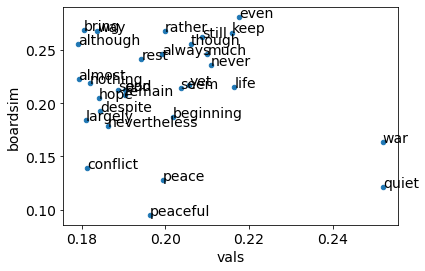

In [ ]:
## glove accuracy decreases if board similarity is completely ignored
## war-quiet is a good example -- "even" and "life" are technically closer to war-quiet, but very similar to other board words
## "peace" is a nice balance
boardname = 'e1_board6_words'

cluesims, boardsims, clue_sims_new = speaker_board_func_detailed(board_combos[boardname], boards[boardname])
idx = 2
clue_sims_main = cluesims[idx]
boardsims_main = boardsims[idx]
## we can find which "clues" have the highest board similarities vs. target similarities
print(boards[boardname])

highest_to_target = (-clue_sims_main).argsort()[:30]
vals = clue_sims_main[highest_to_target]
words = [list(sample_df["Word"])[x] for x in highest_to_target]
boardsim = boardsims_main[highest_to_target]
df = pd.DataFrame({'vals': vals, 'words': [list(sample_df["Word"])[x] for x in highest_to_target], 'boardsim': boardsims_main[highest_to_target]}, index = words)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string

fig, ax = plt.subplots()
df.plot('vals', 'boardsim', kind='scatter', ax=ax)
plt.rcParams.update({'font.size': 14})

for i, txt in enumerate(words):
    ax.annotate(txt, (vals[i], boardsim[i]))

Text(0.5, 1.0, 'WAR-QUIET board similarities')

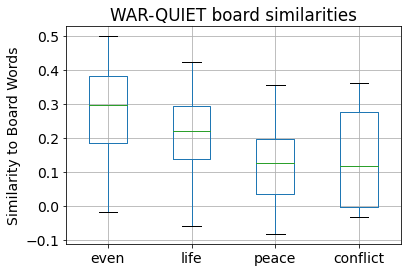

In [ ]:
## also plot similarities of "even", "life", and "peace" to other words on board using clue_sims_new
idx = 2
clue_sims_new_main = clue_sims_new[idx] ## 18 x 12218 array
boardname = 'e1_board6_words'
mainlist = boards[boardname]
#mainlist.remove('war')
#mainlist.remove('quiet')
boardwords_sub = sorted(mainlist) ## clue sims is alphabetical 
c1_index = list(sample_df["Word"]).index('even')
c2_index = list(sample_df["Word"]).index('life')
c3_index = list(sample_df["Word"]).index('peace')
c4_index = list(sample_df["Word"]).index('conflict')

boardsims_clues = clue_sims_new_main[:, [c1_index, c2_index, c3_index, c4_index]]
boardsims_clues
bdf = pd.DataFrame({'even': boardsims_clues[:,0], 'life':boardsims_clues[:,1], 'peace': boardsims_clues[:,2] ,'conflict': boardsims_clues[:,3] }, index = boardwords_sub)
bb = bdf.boxplot()
bb.set_ylabel('Similarity to Board Words')
bb.set_title('WAR-QUIET board similarities')


## Obtain Distance of Prediction from Actual Clue

In [ ]:
## instead of pure accuracy (0/1), we can obtain similarity of prediction to actual modal clue
## read in corrected clues file (excluding stemmed predictions, plurals etc.)
## reading in the words from E1
with tf.device('/device:GPU:0'):
  board_func = pd.read_csv("/content/drive/My Drive/Connector-RSA-Project/speaker_boardfunc_df.csv")
board_func.tail()

board_func = board_func.loc[board_func['Model'] == 'BERT-cat']
len(board_func)

715

In [ ]:
def create_similarity_matrix(matrix, vector, N):
  matrix = 1-scipy.spatial.distance.cdist(matrix, vector, 'cosine').reshape(-1)
  matrix = matrix.reshape((N,N))
  return matrix

sim_matrices = {}
for key, embeddings in representations.items() :
  sim_matrices[key] = create_similarity_matrix(embeddings, embeddings, embeddings.shape[0])
  
clue = []
board_func_sample = board_func
for index, row in board_func_sample.iterrows():
  cluesim = row['Model'][list(sample_df["Word"]).index(row["new_pred"]),list(sample_df["Word"]).index(row["topClue"])]
  clue.append(cluesim)
board_func_sample["clue_distance"] = clue
board_func_sample.tail()

,wordpair,Model,alpha,new_pred,new_rsa_acc,topClue,clue_distance
2855,feet-chapel,BERT-cat,1.0,cottage,0,Jesus,0.685187
2856,feet-chapel,BERT-cat,1.0,cottage,0,kneel,0.537605
2857,feet-chapel,BERT-cat,1.0,cottage,0,wash,0.676638
2858,feet-chapel,BERT-cat,1.0,cottage,0,worship,0.679557
2859,chair-table,BERT-cat,1.0,stool,0,furniture,0.771777


In [ ]:
board_func_sample.to_csv("speaker_boardfunc_df_model.csv")
!cp speaker_boardfunc_df_model.csv "drive/My Drive/Connector-RSA-Project/"

# BERT Contextual Analyses

## Guesser

In [ ]:
## using glovearray_answer and gloverray_clue, we can try to see which answer is closest to a given word?

## here we get the data for the experiment
with tf.device('/device:GPU:0'):
  expdata = pd.read_csv("/content/drive/My Drive/Connector-RSA-Project/final_board_clues_all.csv", encoding= 'unicode_escape')
expdata.head() ## 1096 rows of data

,Experiment,Board,Word1,Word2,Clue1,clueCount,wordpair
0,E1,TrialList1,exam,algebra,calculus,1,exam - algebra
1,E1,TrialList1,exam,algebra,equation,1,exam - algebra
2,E1,TrialList1,exam,algebra,knowledge,1,exam - algebra
3,E1,TrialList1,exam,algebra,math,22,exam - algebra
4,E1,TrialList1,exam,algebra,school,2,exam - algebra


In [ ]:
## merge expdata with combined_boards
expdata_new = pd.merge(expdata,combined_boards_df,on=['Board', 'Experiment'],how='left')
expdata_new.head()

,Experiment,Board,Word1,Word2,Clue1,clueCount,wordpair,boardwords,boardnames
0,E1,TrialList1,exam,algebra,calculus,1,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words
1,E1,TrialList1,exam,algebra,equation,1,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words
2,E1,TrialList1,exam,algebra,knowledge,1,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words
3,E1,TrialList1,exam,algebra,math,22,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words
4,E1,TrialList1,exam,algebra,school,2,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words


In [ ]:
expdata_new

,Experiment,Board,Word1,Word2,Clue1,clueCount,wordpair,boardwords,boardnames
0,E1,TrialList1,exam,algebra,calculus,1,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words
1,E1,TrialList1,exam,algebra,equation,1,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words
2,E1,TrialList1,exam,algebra,knowledge,1,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words
3,E1,TrialList1,exam,algebra,math,22,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words
4,E1,TrialList1,exam,algebra,school,2,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words
...,...,...,...,...,...,...,...,...,...
1091,E2,TrialList9,weird,trauma,strange,1,weird - trauma,"[male, guest, sleep, hammock, candle, wick, ol...",e2_board9_words
1092,E2,TrialList9,weird,trauma,trigger,1,weird - trauma,"[male, guest, sleep, hammock, candle, wick, ol...",e2_board9_words
1093,E2,TrialList9,weird,trauma,uncomfortable,2,weird - trauma,"[male, guest, sleep, hammock, candle, wick, ol...",e2_board9_words
1094,E2,TrialList9,weird,trauma,unusual,1,weird - trauma,"[male, guest, sleep, hammock, candle, wick, ol...",e2_board9_words


In [ ]:
answervecs.shape

(20, 768)

In [ ]:
board_combos['e1_board1_words']

,Word1,Word2,wordpair
0,angry,adore,angry-adore
1,angry,burglar,angry-burglar
2,angry,rumor,angry-rumor
3,angry,depth,angry-depth
4,angry,anchor,angry-anchor
...,...,...,...
185,void,yarn,void-yarn
186,void,better,void-better
187,couch,yarn,couch-yarn
188,couch,better,couch-better


In [ ]:
boards['e1_board1_words']

['angry',
 'adore',
 'burglar',
 'rumor',
 'depth',
 'anchor',
 'exam',
 'algebra',
 'giggle',
 'abnormal',
 'instruction',
 'write',
 'outfit',
 'bandanna',
 'pen',
 'lead',
 'void',
 'couch',
 'yarn',
 'better']

In [ ]:
pd.DataFrame({'Word': boards['e1_board1_words']})

,Word
0,angry
1,adore
2,burglar
3,rumor
4,depth
5,anchor
6,exam
7,algebra
8,giggle
9,abnormal


In [ ]:
from scipy.spatial.distance import cosine

def find_closest(clue_vec, answer_vec, context_board):
  # grab subset of words in given board and their corresponding glove vectors
  board_df = pd.DataFrame({'Word': boards[context_board]})
  #print("board_df:",board_df)
  board_word_indices = list(board_df.index)
  board_words = board_df["Word"]
  board_vectors = answer_vec
  combs_df = board_combos[context_board]

  ## clue_sims is the similarity of ALL clues in full searchspace (size N) to EACH word on board (size 20)
  clue_sims = 1-scipy.spatial.distance.cdist(clue_vec, answer_vec, 'cosine')
  clue_sims = clue_sims.reshape((20,1))

  ## once we have the similarities of the clue to the words on the board
  ## we define a multiplicative function that maximizes these similarities

  ## next we find the product of similarities between c-w1 and c-w2 for that specific board's 190 word-pairs
  ## this gives us a 190 x N array of product similarities for a given combs_df
  ## specifically, for each possible pair, pull out 
  f_w1_list =  np.array([clue_sims[board_df[board_df["Word"]==row["Word1"]].index.values[0]]
                         for  index, row in combs_df.iterrows()])
  f_w2_list =  np.array([clue_sims[board_df[board_df["Word"]==row["Word2"]].index.values[0]] 
                         for  index, row in combs_df.iterrows()])
  
  combs_df["prod"] = f_w1_list * f_w2_list
  return list(combs_df.nlargest(1, ['prod'])["wordpair"])

  # ## we want to get the product of these clue similarities to find the two words with the maximum product
  
  # y = np.array(sims)
  # y_sorted = np.argsort(-y) ## gives sorted indices
  # top20_indices = y_sorted[:5]
  # mainlist = list(np.concatenate(top20_indices).flat)
  # return [board[x] for x in mainlist[:2]]
  #w1 = [list(sample_df["Word"])[i] for i in top20_indices]
  #return top20_indices

In [ ]:
## board1 vecs for calculus
answervecs = glovearray_answer[:20]
## each clue also has "20" embeddings -- corresponding to "clue is most similar to X" where X is each of the 20 words on the board
## we can average these to get an approximate embedding for the clue for that board
cluevec = glovearray_clue[:20].mean(axis=0)
#cluevec = cluevec.mean(axis =0)
print(cluevec.shape)
find_closest(cluevec.reshape((1,768)), answervecs, 'e1_board1_words')

(768,)


['algebra-instruction']

In [ ]:
contextual_bert_guess = []
for index, row in expdata_new.iterrows():
  ## get average "clue" embedding for that board
  clue = row["Clue1"]
  #print("index:", index)
  #print("start:", index*20)
  #print("end:", (index+1)*20)
  ## for each answer there is a unique embedding, so we need to average the 20 embeddings to get an overall clue embedding for the board
  cluevec = glovearray_clue[index*20:(index+1)*20].mean(axis = 0)
  #print(cluevec.shape)
  ## for every clue there are 20 vectors in glovearray_answer
  answervecs = glovearray_answer[index*20:(index+1)*20]
  #print(answervecs.shape)
  guess = find_closest(cluevec.reshape((1,768)), answervecs, row["boardnames"])
  #print(f"for clue {clue}, guess is {guess}")
  contextual_bert_guess.append(guess)

expdata_new["contextual_bert_literal"] = contextual_bert_guess
expdata_new.head()



,Experiment,Board,Word1,Word2,Clue1,clueCount,wordpair,boardwords,boardnames,contextual_bert_literal
0,E1,TrialList1,exam,algebra,calculus,1,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words,[algebra-instruction]
1,E1,TrialList1,exam,algebra,equation,1,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words,[algebra-bandanna]
2,E1,TrialList1,exam,algebra,knowledge,1,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words,[giggle-instruction]
3,E1,TrialList1,exam,algebra,math,22,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words,[algebra-instruction]
4,E1,TrialList1,exam,algebra,school,2,exam - algebra,"[angry, adore, burglar, rumor, depth, anchor, ...",e1_board1_words,[instruction-outfit]


In [ ]:
expdata_new.tail()


,Experiment,Board,Word1,Word2,Clue1,clueCount,wordpair,boardwords,boardnames,contextual_bert_literal
1091,E2,TrialList9,weird,trauma,strange,1,weird - trauma,"[male, guest, sleep, hammock, candle, wick, ol...",e2_board9_words,[weird-happen]
1092,E2,TrialList9,weird,trauma,trigger,1,weird - trauma,"[male, guest, sleep, hammock, candle, wick, ol...",e2_board9_words,[guest-fly]
1093,E2,TrialList9,weird,trauma,uncomfortable,2,weird - trauma,"[male, guest, sleep, hammock, candle, wick, ol...",e2_board9_words,[weird-sore]
1094,E2,TrialList9,weird,trauma,unusual,1,weird - trauma,"[male, guest, sleep, hammock, candle, wick, ol...",e2_board9_words,[guest-fly]
1095,E2,TrialList9,weird,trauma,you,1,weird - trauma,"[male, guest, sleep, hammock, candle, wick, ol...",e2_board9_words,[guest-happen]


In [ ]:
expdata_new.to_csv("guesser_np_bert_contextual.csv")
!cp guesser_np_bert_contextual.csv "drive/My Drive/Connector-RSA-Project/"

In [ ]:
## need to still get RSA-based predictions for this -- but these will depend on speaker analyses. 